# CHEM 101.6 Project1

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulations of Butane using the OpenMM engine 


# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    OpenMM (https://openmm.org/)
2.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    Numpy (https://numpy.org/)
5.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

Load libraries in conda enviroment:

conda install -c conda-forge openmm 

conda install -c conda-forge jupyterlab

conda install -c conda-forge mdtraj




In [2]:
import numpy as np
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import sys
import openmm as mm
from openmm import app
from openmm import unit
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import pandas as pd
from statistics import mean, stdev
from matplotlib import colors
import mdtraj as md
import seaborn as sns


In [10]:
workdir='./work_new2/'
datadir='./data/'
outdir='./out_new2/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

./data/butane.pdb
./data/butane.gaff2.xml


In [11]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528692127867 kJ/mol
Potential energy after minimization is 5.295271861905595 kJ/mol


In [12]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,43.07694625500898,361.5993266127101
2000,53.00642068748165,371.2355031535059


In [13]:
os.path.join(workdir, "butane_sim.dcd")

'./work_new2/butane_sim.dcd'

In [14]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD or XTC
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.XTCReporter(os.path.join(workdir, "butane_sim.xtc"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,48.78105291248282,176.00643951482115,--
500000,999.9999999901769,34.432476306095865,328.80491388205934,7.93e+03
750000,1499.9999999783536,57.88827317216542,491.2085129434396,7.98e+03
1000000,1999.9999999665301,46.160117982329794,308.6847754232856,7.99e+03
1250000,2499.9999999547067,51.92233271060128,292.9299038757728,7.93e+03
1500000,2999.9999999428833,47.89906191326684,323.6763840176116,7.93e+03
1750000,3499.99999993106,42.56550146077513,268.48384915774795,7.9e+03
2000000,3999.9999999192364,35.3576679714668,301.3307445244379,7.93e+03
2250000,4499.9999999992715,32.8078834323197,364.23881181448877,7.94e+03
2500000,5000.000000101135,37.004067807627465,146.55624679220332,7.96e+03
2750000,5500.000000202998,56.50506664908699,348.4799239791994,7.96e+03
3000000,6000.000000304862,35.566997718535305,222.44875505078878,7.92e+03
3250000,6500.000000406725,48.8139665972

In [15]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_sim.xtc"), top=PDB_file_name)
traj


<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x185653f7fd0>

In [16]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

In [17]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x185659c55d0>

In [18]:
C_sel=top.select("type C")
print(C_sel)
top.atom(10)
for atom in C_sel:
    print(atom,top.atom(atom))

H_sel=top.select("type H")
for atom in H_sel:
    print(atom,top.atom(atom))

[ 0  4  7 10]
0 NBU1-C1
4 NBU1-C2
7 NBU1-C3
10 NBU1-C4
1 NBU1-H11
2 NBU1-H12
3 NBU1-H13
5 NBU1-H21
6 NBU1-H22
8 NBU1-H31
9 NBU1-H32
11 NBU1-H41
12 NBU1-H42
13 NBU1-H43


In [19]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


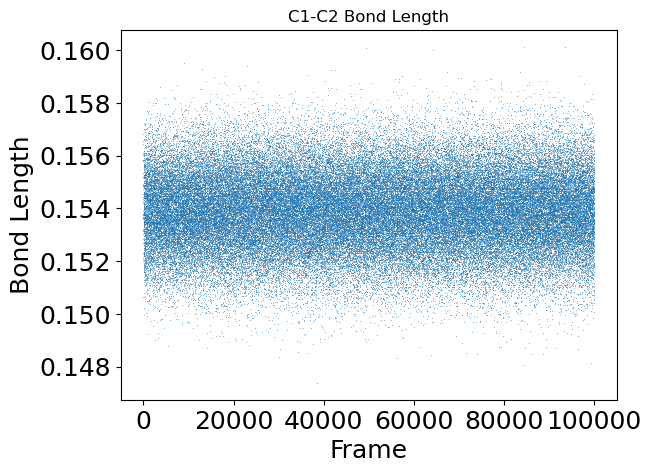

In [20]:
#Compute Some Distances and plot the time course
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C1C2bondlength,linewidth=1)
plt.plot(C1C2bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
#plt.xlim([0,1000])

plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C1-C2 Bond Length')
plt.show()

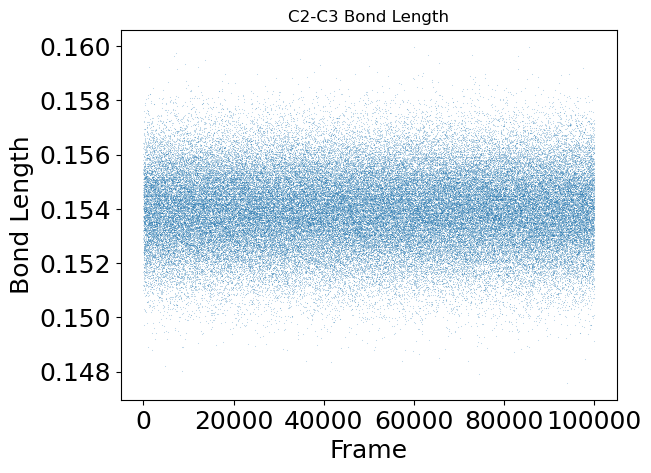

In [21]:
bond_indices = [4, 7] 
C2C3bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C2C3bondlength)
plt.plot(C2C3bondlength,linewidth=0,marker='x',markersize=.05)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C2-C3 Bond Length')
plt.show()

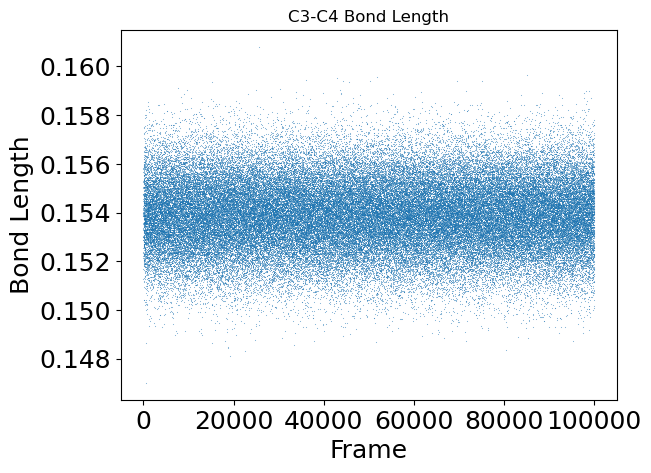

In [22]:
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C3C4bondlength)
plt.plot(C3C4bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C3-C4 Bond Length')
plt.show()

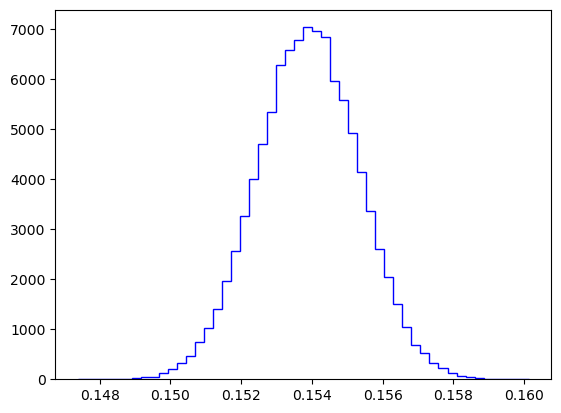

In [23]:
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.show()

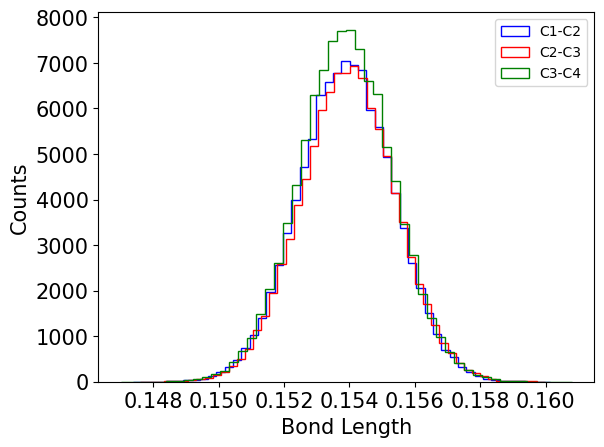

In [24]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.hist(C2C3bondlength,label='C2-C3',color='r',histtype='step',bins=50)
plt.hist(C3C4bondlength,label='C3-C4',color='g',histtype='step',bins=50)
plt.legend(loc='upper right')
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

Lets Write Functions to Calculate the Variance ($\sigma^2$) and Standard Deviation ($\sigma$)

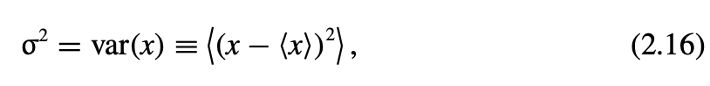

In [38]:
######Class Activtiy: Calculate the Variance and Standard Deviation of Each Bond Length######


In [25]:
###SOLUTION###
def variance(data):
    ave=np.average(data)
    var= np.average((data-ave)**2)
    std=var**0.5
    return var,std

C1C2var,C1C2std=variance(C1C2bondlength)
C2C3var,C2C3std=variance(C2C3bondlength)
C3C4var,C3C4std=variance(C3C4bondlength)

print("C1-C2 variance:",C1C2var,"C1-C2 standard deviation:",C1C2std)
print("C2-C3 variance:",C2C3var,"C1-C2 standard deviation:",C2C3std)
print("C3-C4 variance:",C2C3var,"C1-C2 standard deviation:",C3C4std)

C1-C2 variance: 2.0557047e-06 C1-C2 standard deviation: 0.0014337728991875504
C2-C3 variance: 2.0694195e-06 C1-C2 standard deviation: 0.0014385476883996785
C3-C4 variance: 2.0694195e-06 C1-C2 standard deviation: 0.0014264829655175795


In [26]:
#Lets Check Our Answers with the Built In Numpy Libraries
print("C1-C2 average:",np.average(C1C2bondlength),"variance:",np.var(C1C2bondlength),"std-dev:",np.std(C1C2bondlength))
print("C2-C3 average:",np.average(C2C3bondlength),"variance:",np.var(C2C3bondlength),"std-dev:",np.std(C2C3bondlength))
print("C3-C4 average:",np.average(C3C4bondlength),"variance:",np.var(C3C4bondlength),"std-dev:",np.std(C3C4bondlength))

C1-C2 average: 0.15389769 variance: 2.0557047e-06 std-dev: 0.0014337728
C2-C3 average: 0.15395825 variance: 2.0694195e-06 std-dev: 0.0014385477
C3-C4 average: 0.15389772 variance: 2.0348537e-06 std-dev: 0.0014264829


***Class Activity: Lets Check if These Bond Lengths Are Correlated and Calculate the Coerrleation Coefficents***

***First Calculate a Best Fit Line****

We can do this using the np.polyfit function:

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

***Now Calculate the Perason Correlation Coefficient***
We can use numpy to calculate the correlation coeffient 

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

This function works for n-arrays, so it will report correlation coefficient matrix, and we need to select our coefficient of interest, which in our case is the off diagnol  


In [27]:
#Switch to a 1D array 
np.shape(C1C2bondlength[:,0])

(100000,)

Line Parameters: [0.50017272 0.07697877]


C:\Users\grace\AppData\Local\Temp\ipykernel_15588\3244865060.py:7: RankWarning: Polyfit may be poorly conditioned
  line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)


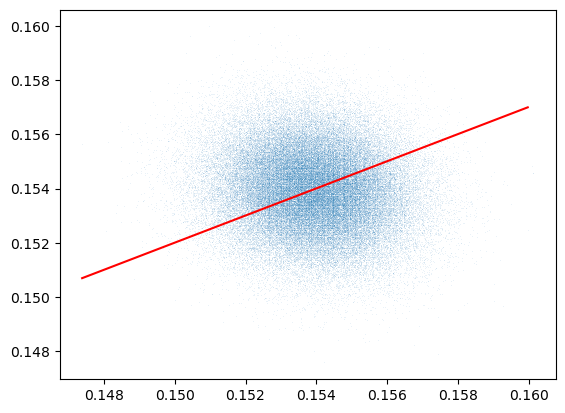

r2: -0.10595616640173064
Line Parameters: [0.49997867 0.0769489 ]


C:\Users\grace\AppData\Local\Temp\ipykernel_15588\3244865060.py:21: RankWarning: Polyfit may be poorly conditioned
  line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)


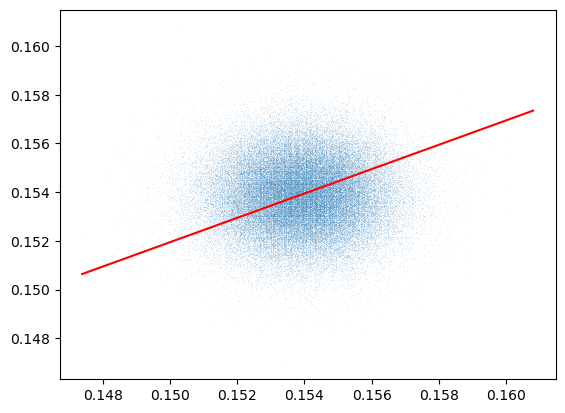

r2: 0.013243032759942397
Line Parameters: [0.49977943 0.07694852]


C:\Users\grace\AppData\Local\Temp\ipykernel_15588\3244865060.py:34: RankWarning: Polyfit may be poorly conditioned
  line_fit=np.polyfit(C2C3bondlength[:,0],C3C4bondlength[:,0],1)


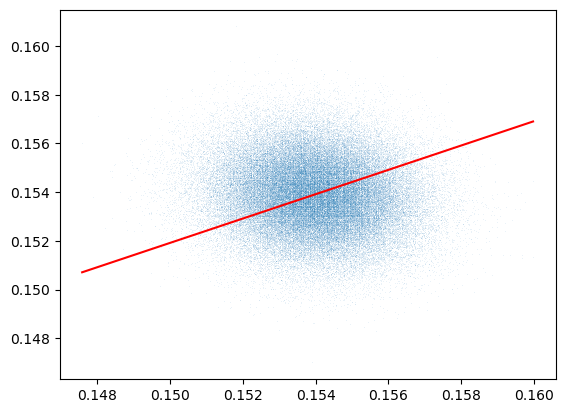

r2: -0.10077378503548154


In [28]:
#####Are these bond lengths correlated?##### 
###Calculate and plot a best fit line, and calculate the correlation coefficient####
#######SOLUTION###########
#C1C2 and C2C3

plt.scatter(C1C2bondlength,C2C3bondlength,marker='x',s=0.1,linewidth=0.05)
line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C2C3bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

r=np.corrcoef(C1C2bondlength[:,0], C2C3bondlength[:,0])
print("r2:",r[0,1])

#C1C2 and C3C4
plt.scatter(C1C2bondlength,C3C4bondlength,marker='x',s=0.1,linewidth=0.05)

line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C3C4bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()

r=np.corrcoef(C1C2bondlength[:,0], C3C4bondlength[:,0])
print("r2:",r[0,1])

#lets look at the last two comparision for fun, C2C3 and C3C4
plt.scatter(C2C3bondlength,C3C4bondlength,marker='x',s=0.1,linewidth=0.05)

line_fit=np.polyfit(C2C3bondlength[:,0],C3C4bondlength[:,0],1)
x = np.linspace(min(C2C3bondlength[:,0]), max(C2C3bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()

r=np.corrcoef(C2C3bondlength[:,0], C3C4bondlength[:,0])
print("r2:",r[0,1])

<Figure size 640x480 with 0 Axes>

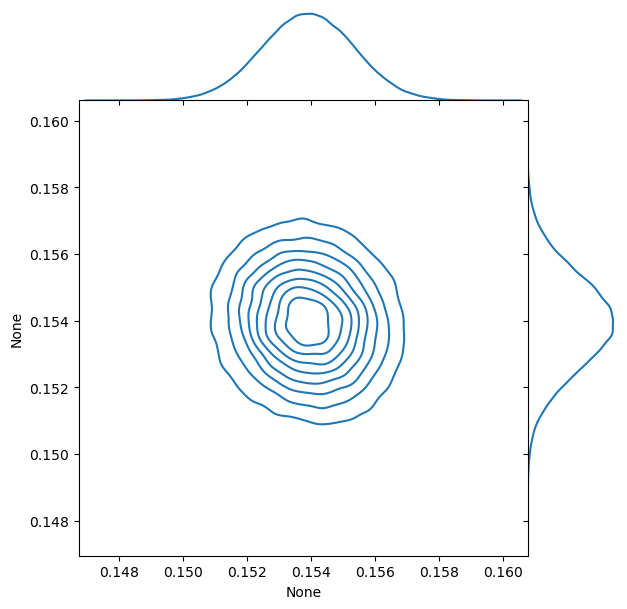

In [30]:
import seaborn as sns
plt.clf()
sns.jointplot(x=C1C2bondlength[:,0],y=C2C3bondlength[:,0],kind='kde',space=0,thresh=0)

<Figure size 640x480 with 0 Axes>

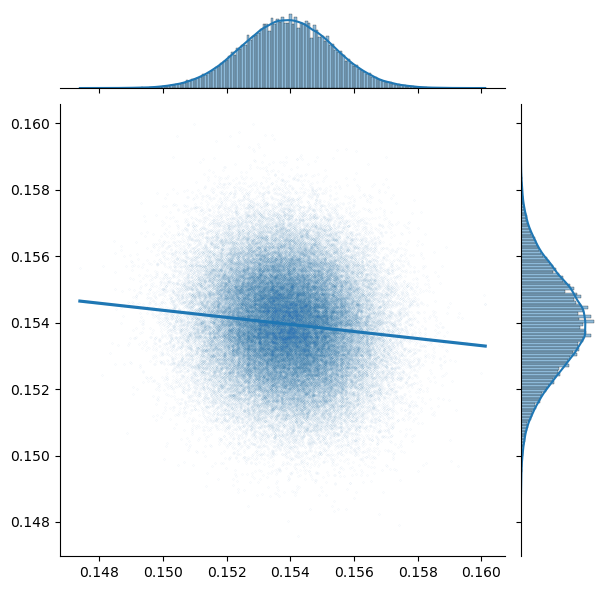

In [29]:
import seaborn as sns
plt.clf()
sns.jointplot(x=C1C2bondlength[:,0],y=C2C3bondlength[:,0],kind='reg',scatter_kws={'s':0.001})

**WEEK 1 Homework Question:  Why does one pair of these bonds appear slightly more correlated than the other?**

The first pair of bonds, C1C2 and C2C3, appear slightly more correlated than the other, C1C2 and C3C4, because they share a carbon. This can also be seen for C2C3 and C3C4. 

***Class Activity*** 

***Lets write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

Lets Turn these histograms into a probability densities and then fit them to a
normal (Gaussian) Distribution

https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

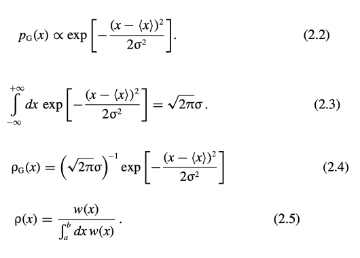
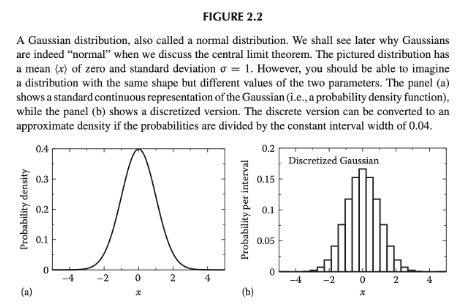

[    1     2    29   104   410  1321  3215  6737 11408 15913 17692 16580
 12687  7756  3891  1539   546   129    34     3] [0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935 0.16   ]
a: 0.1790917382642769 x_0: 0.15390226479337224 fit_sigma: -0.0014496206944062133


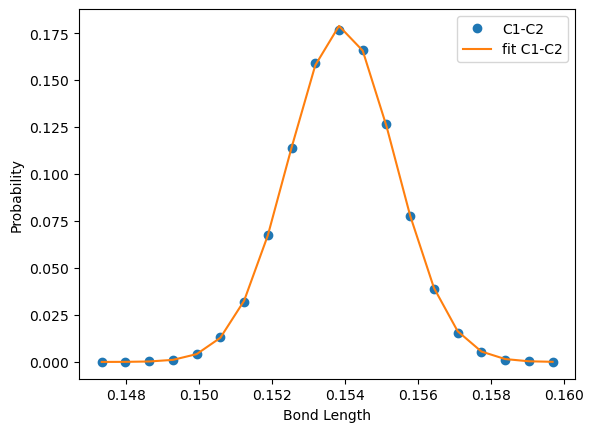

In [31]:
#Lets calculate a Probability Density and fit a gaussian to these
#First lets pull out the data in a formate we can fit
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

from scipy.optimize import curve_fit

####SOLUTION####

#First we convery our histogram into bin centers and probabilities
#isntead of bin edges and counts:

counts, edges = np.histogram(C1C2bondlength,bins=20,range=[0.147,0.160])
print(counts,edges)
centers = edges[:-1] + np.diff(edges)/2
density=counts/(np.sum(counts))

### THIS IS WHAT YOU WANT TO TURN INTO A FUNCTION FOR HOMEWORK ####

###Now we define a gaussian function that we'll fit to our probability densities
def gauss(x,a, x0, sigma):
    return(a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss,x,y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x_0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss(x,fit_a,fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma]


C1C2_fit,C1C2_fit_params=fit_gauss(centers,density)

plt.plot(centers,density,'o',label='C1-C2')
plt.plot(centers,C1C2_fit,'-',label='fit C1-C2')
plt.legend()
plt.xlabel('Bond Length')
plt.ylabel('Probability')
plt.show()

#C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)


***Homework Porblem 1:  Can you write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

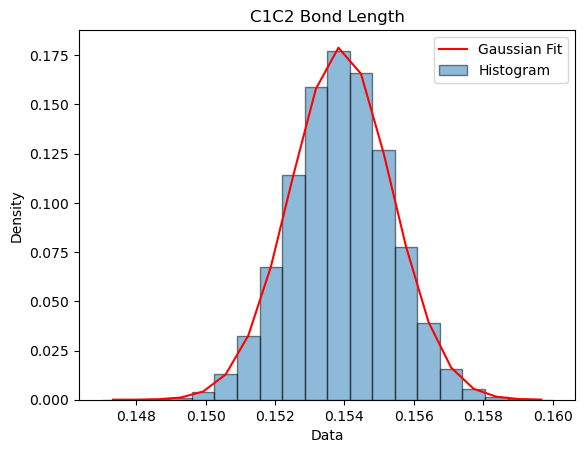

C1C2 Bond Length: Optimal parameters (center, width, amplitude): [0.15390226 0.00144962 0.17909174]
Densities: [1.00003000e-05 2.00006000e-05 2.90008700e-04 1.04003120e-03
 4.10012300e-03 1.32103963e-02 3.21509645e-02 6.73720212e-02
 1.14083423e-01 1.59134774e-01 1.76925308e-01 1.65804974e-01
 1.26873806e-01 7.75623269e-02 3.89111673e-02 1.53904617e-02
 5.46016380e-03 1.29003870e-03 3.40010200e-04 3.00009000e-05]
Centers: [0.14732501 0.147975   0.148625   0.149275   0.149925   0.15057501
 0.151225   0.15187499 0.15252501 0.153175   0.153825   0.154475
 0.15512499 0.15577501 0.156425   0.15707499 0.157725   0.158375
 0.159025   0.159675  ]


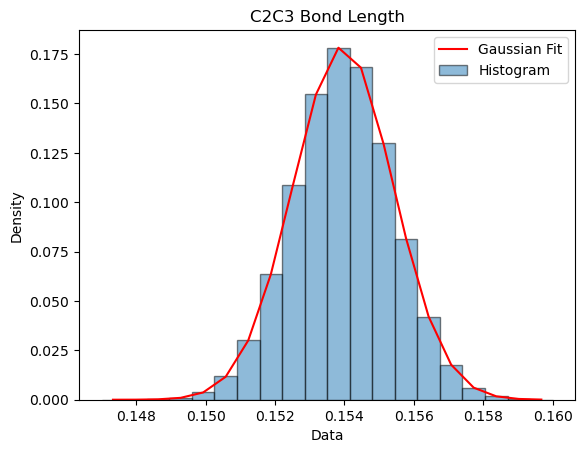

C2C3 Bond Length: Optimal parameters (center, width, amplitude): [0.1539614  0.00144796 0.17903217]
Densities: [1.0000e-05 3.0000e-05 2.6000e-04 1.0300e-03 3.7400e-03 1.1890e-02
 3.0450e-02 6.3630e-02 1.0872e-01 1.5487e-01 1.7796e-01 1.6825e-01
 1.2997e-01 8.1510e-02 4.1940e-02 1.7490e-02 6.1100e-03 1.6700e-03
 3.7000e-04 1.0000e-04]
Centers: [0.14732501 0.147975   0.148625   0.149275   0.149925   0.15057501
 0.151225   0.15187499 0.15252501 0.153175   0.153825   0.154475
 0.15512499 0.15577501 0.156425   0.15707499 0.157725   0.158375
 0.159025   0.159675  ]


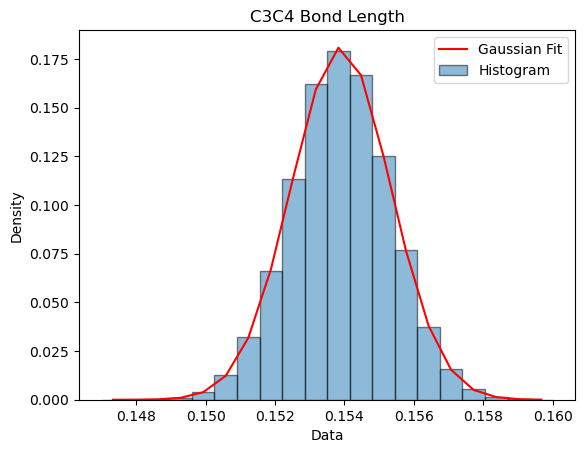

C3C4 Bond Length: Optimal parameters (center, width, amplitude): [0.1538955  0.00143064 0.18104401]
Densities: [1.00001000e-05 1.00001000e-05 1.90001900e-04 1.06001060e-03
 4.01004010e-03 1.27801278e-02 3.22303223e-02 6.58906589e-02
 1.13231132e-01 1.62171622e-01 1.79121791e-01 1.67021670e-01
 1.25051251e-01 7.68207682e-02 3.74903749e-02 1.55801558e-02
 5.30005300e-03 1.65001650e-03 2.80002800e-04 1.00001000e-04]
Centers: [0.14732501 0.147975   0.148625   0.149275   0.149925   0.15057501
 0.151225   0.15187499 0.15252501 0.153175   0.153825   0.154475
 0.15512499 0.15577501 0.156425   0.15707499 0.157725   0.158375
 0.159025   0.159675  ]


In [34]:
#Can you write a function to calculate the histogram, return the density and centers,
#and then fit a guassian to each of these distributions? 

####HOMEWORK SOLUTION ####
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define dataset arrays again
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
bond_indices = [4, 7] 
C2C3bondlength = md.compute_distances(traj, [bond_indices])
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])

# Make a list
allbonds = [
    {'data': C1C2bondlength, 'title': 'C1C2 Bond Length'},
    {'data': C2C3bondlength, 'title': 'C2C3 Bond Length'},
    {'data': C3C4bondlength, 'title': 'C3C4 Bond Length'}
]
 
# Define Gaussian function
def gaussian(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def fit_histogram_with_gaussian(data, title='', plot=True):
    # Calculate histogram
    counts, edges = np.histogram(data, bins=20, range=[0.147, 0.160])
    centers = edges[:-1] + np.diff(edges) / 2
    density = counts / np.sum(counts)

    # Compute initial parameter guesses
    initial_guess_a = max(density)  # Initial guess for the peak height
    initial_guess_x0 = np.mean(centers)  # Initial guess for the peak position
    initial_guess_sigma = np.std(centers)  # Initial guess for the standard deviation

    # Define initial guesses as a tuple
    initial_guess = (initial_guess_x0, initial_guess_sigma, initial_guess_a)
    # Pass initial_guess to curve_fit function
    popt, _ = curve_fit(gaussian, centers, density, p0=initial_guess) 

    # Plot the histogram and fitted Gaussian
    if plot:
        plt.bar(centers, density, width=np.diff(edges), edgecolor='k', alpha=0.5, label='Histogram')
        plt.plot(centers, gaussian(centers, *popt), color='red', label='Gaussian Fit')
        plt.title(title)
        plt.xlabel('Data')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

    return density, centers, popt

# Iterate across all bonds
for bond in allbonds:
    data = bond['data']
    title = bond['title']
    density, centers, popt = fit_histogram_with_gaussian(data, title=title)
    print(f"{title}: Optimal parameters (center, width, amplitude):", popt)
    print(f"Densities: {density}")
    print(f"Centers: {centers}")

**Week 1 Homework Problem #2: convert these probability distributions to culmulative distribution functions**

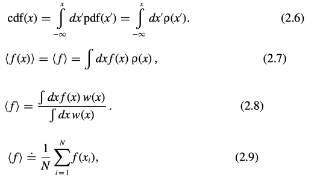

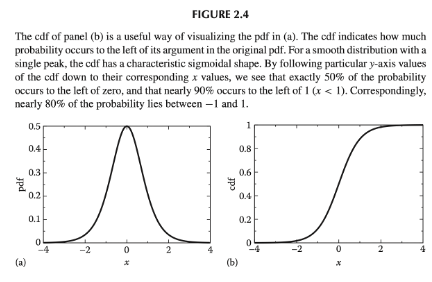

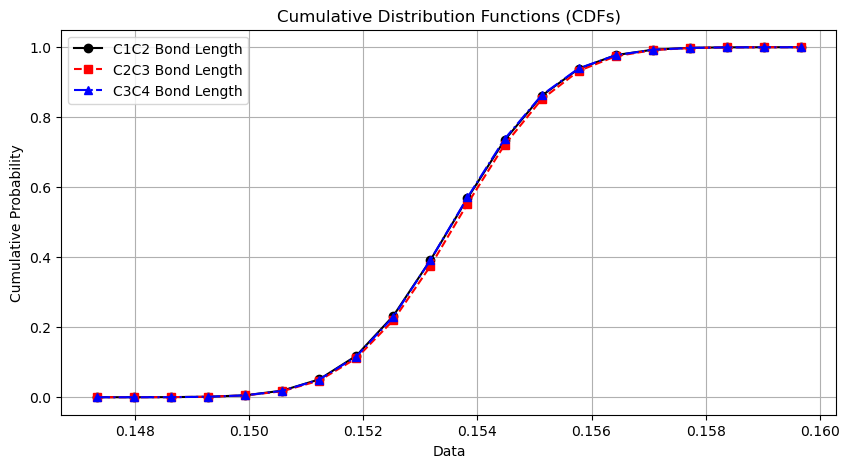

In [38]:
###WEEK 1 HOMEWORK#### 

####HOMEWORK SOLUTION####
#To edit the code above to convert the probability distributions into cumulative distribution functions.
#You can use np.cumsum to normalize the density and compute the cumulative sum like this: 
####HOMEWORK SOLUTION ####
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define dataset arrays again
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
bond_indices = [4, 7] 
C2C3bondlength = md.compute_distances(traj, [bond_indices])
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])

# Make a list
allbonds = [
    {'data': C1C2bondlength, 'title': 'C1C2 Bond Length'},
    {'data': C2C3bondlength, 'title': 'C2C3 Bond Length'},
    {'data': C3C4bondlength, 'title': 'C3C4 Bond Length'}
]

# Define Gaussian function
def gaussian(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def fit_histogram_with_gaussian(data, title='', plot=True):
    # Calculate histogram
    counts, edges = np.histogram(data, bins=20, range=[0.147, 0.160])
    centers = edges[:-1] + np.diff(edges) / 2
    density = counts / np.sum(counts)

    # Compute initial parameter guesses
    initial_guess_a = max(density)  # Initial guess for the peak height
    initial_guess_x0 = np.mean(centers)  # Initial guess for the peak position
    initial_guess_sigma = np.std(centers)  # Initial guess for the standard deviation

    # Define initial guesses as a tuple
    initial_guess = (initial_guess_x0, initial_guess_sigma, initial_guess_a)
    # Pass initial_guess to curve_fit function
    popt, _ = curve_fit(gaussian, centers, density, p0=initial_guess) 
    
    # Convert density to CDF
    cdf = pdf_to_cdf(density)
    
    return density, centers, popt  # Return calculated values

def pdf_to_cdf(density):
    # Calculate the cumulative sum of the density
    cumulative_density = np.cumsum(density)
    return cumulative_density

# Plot cumulative distribution functions with different line styles, markers, and colors
plt.figure(figsize=(10, 5))
line_styles = ['-', '--', '-.']  # Define line styles for each dataset
markers = ['o', 's', '^']  # Define marker styles for each dataset
colors = ['black', 'red', 'blue']  # Define colors for each dataset
for i, bond in enumerate(allbonds):
    data = bond['data']
    title = bond['title']
    density, centers, popt = fit_histogram_with_gaussian(data, title=title)
    cdf = pdf_to_cdf(density)
    plt.plot(centers, cdf, label=title, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], color=colors[i % len(colors)])  # Cycle through line styles, markers, and colors

plt.title('Cumulative Distribution Functions (CDFs)')
plt.xlabel('Data')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()

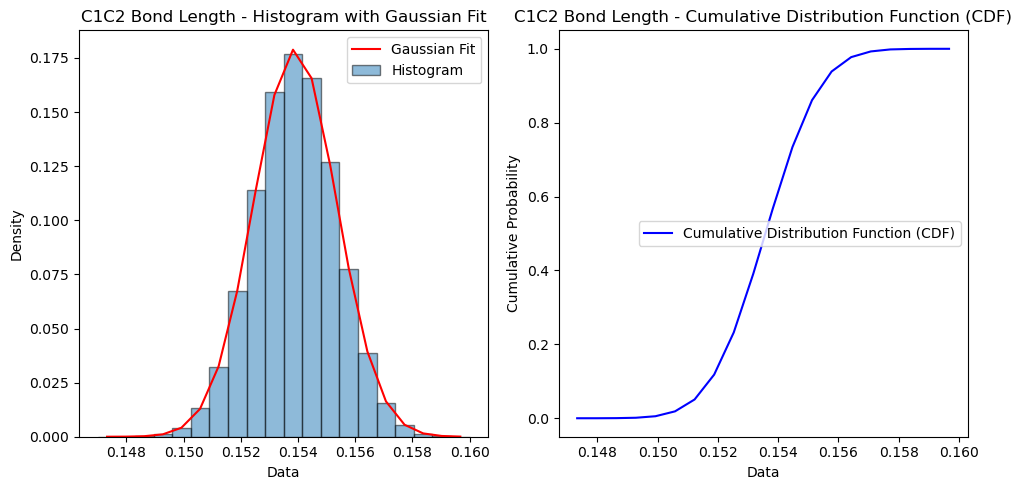

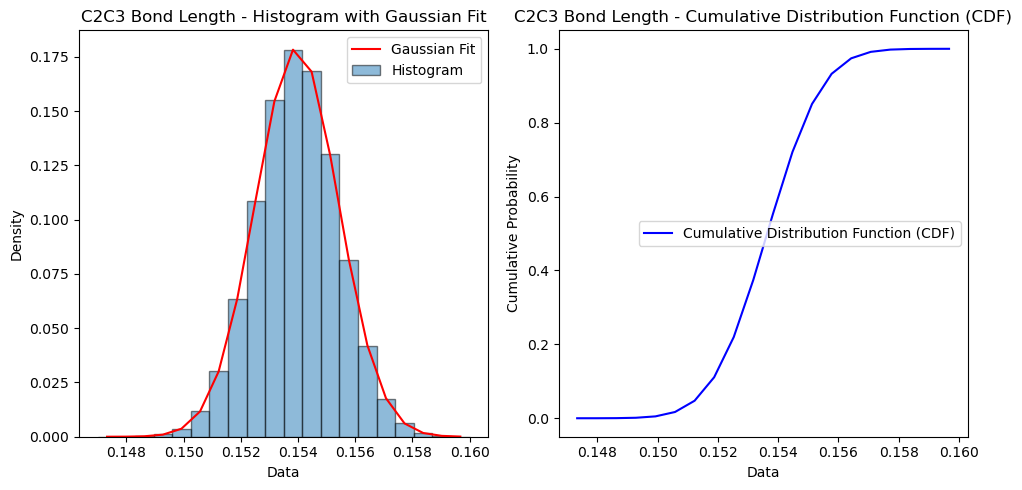

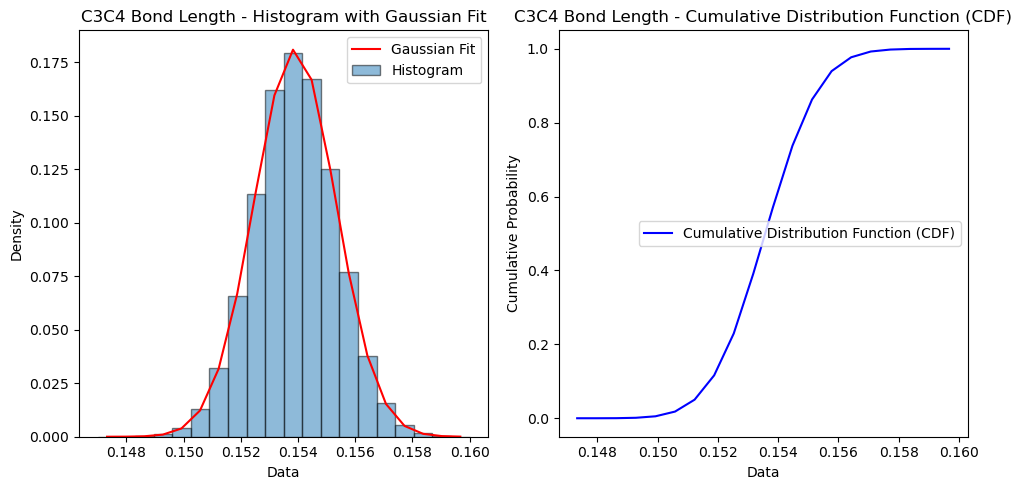

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define dataset arrays again
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
bond_indices = [4, 7] 
C2C3bondlength = md.compute_distances(traj, [bond_indices])
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])

# Make a list
allbonds = [
    {'data': C1C2bondlength, 'title': 'C1C2 Bond Length'},
    {'data': C2C3bondlength, 'title': 'C2C3 Bond Length'},
    {'data': C3C4bondlength, 'title': 'C3C4 Bond Length'}
]

# Define Gaussian function

def fit_histogram_with_gaussian(data, title='', plot=True):
    # Calculate histogram
    counts, edges = np.histogram(data, bins=20, range=[0.147, 0.160])
    centers = edges[:-1] + np.diff(edges) / 2
    density = counts / np.sum(counts)

    # Compute initial parameter guesses
    initial_guess_a = max(density)  # Initial guess for the peak height
    initial_guess_x0 = np.mean(centers)  # Initial guess for the peak position
    initial_guess_sigma = np.std(centers)  # Initial guess for the standard deviation

    # Define initial guesses as a tuple
    initial_guess = (initial_guess_x0, initial_guess_sigma, initial_guess_a)
    # Pass initial_guess to curve_fit function
    popt, _ = curve_fit(gaussian, centers, density, p0=initial_guess) 
    
    # Convert density to CDF
    cdf = pdf_to_cdf(density)
    
    return density, centers, popt  # Return calculated values

def pdf_to_cdf(density):
    # Calculate the cumulative sum of the density
    cumulative_density = np.cumsum(density)
    return cumulative_density

# Iterate across all bonds
for bond in allbonds:
    data = bond['data']
    title = bond['title']
    density, centers, popt = fit_histogram_with_gaussian(data, title=title)
    
    # Plot the histogram and fitted Gaussian
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.bar(centers, density, width=np.diff(edges), edgecolor='k', alpha=0.5, label='Histogram')
    plt.plot(centers, gaussian(centers, *popt), color='red', label='Gaussian Fit')
    plt.title(f"{title} - Histogram with Gaussian Fit")
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.legend()

    plt.subplot(1, 2, 2)
    cdf = pdf_to_cdf(density)
    plt.plot(centers, cdf, color='blue', label='Cumulative Distribution Function (CDF)')
    plt.title(f"{title} - Cumulative Distribution Function (CDF)")
    plt.xlabel('Data')
    plt.ylabel('Cumulative Probability')
    plt.legend()

    plt.tight_layout()
    plt.show()


**WEEK 1 Homework Problem #3: Lets draw some random frames from our trajectory (for example 10,100,1000,10000),  calculate the probability distribution functions for 4 of these random samples, and fit  gaussians to these probability distirbution functions for 1) A Bond Angle 3) A Dihedral Angle.  Why is the Gaussian fit for a dihedral so poor with a large sample? ***


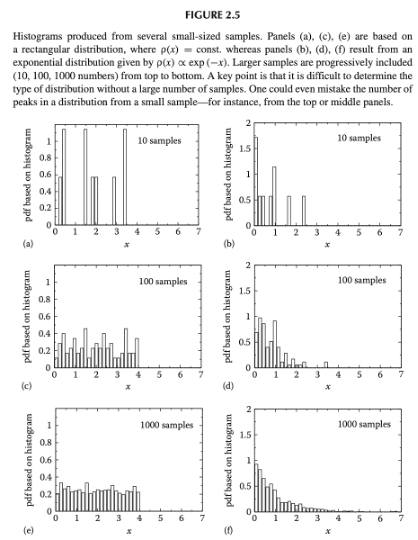

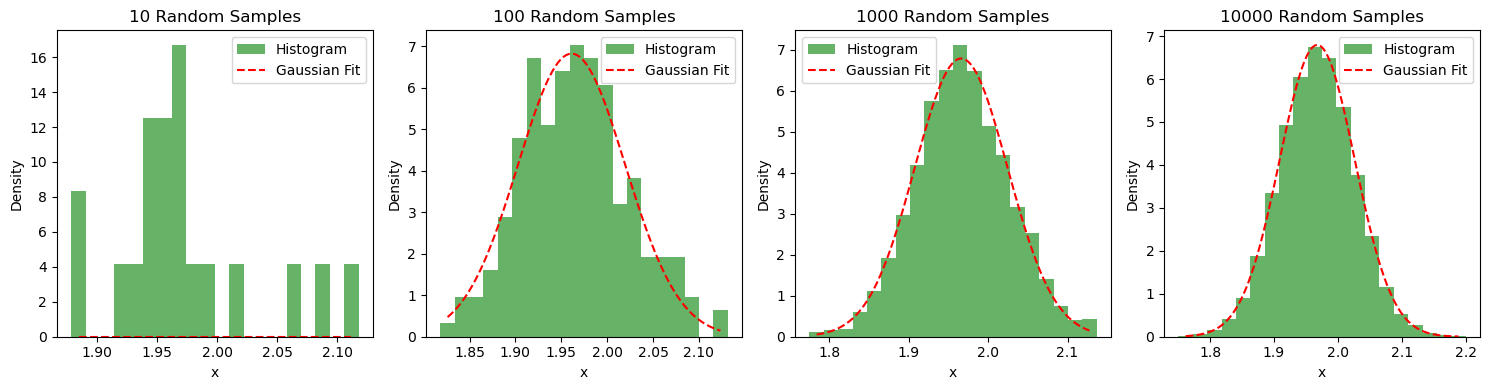

In [41]:
#ADD CODE FOR FITTING GUASSIAN FUNCTIONS TO RANDOM SAMPLES  HERE#
#Draw 10,100,1000 random samples of a bond angle - FIT THEM TO BOND ANGLE

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit

# Compute bond angles
Angle1=[0,4,7]
Angle2=[4,7,10]
ang = md.compute_angles(traj,[Angle1,Angle2])

# Define the numbers of samples to draw
num_samples = [10, 100, 1000, 10000]

#define gaussian
def gaussian(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Plot histograms and fit Gaussians for each number of samples
plt.figure(figsize=(15, 4))
for i, num in enumerate(num_samples, start=1):
    plt.subplot(1, 4, i)
    
    # Generate random indices using np.random.randint
    random_indices = np.random.randint(0, len(ang), size=num)
    
    # Select random samples from the data array
    random_samples = ang[random_indices]

    # Plot histogram
    counts, edges = np.histogram(random_samples.flatten(), bins=20, density=True)
    centers = (edges[:-1] + edges[1:]) / 2
    plt.hist(random_samples.flatten(), bins=20, density=True, alpha=0.6, color='g', label='Histogram')
    
    # Fit Gaussian to the data
    # Compute initial parameter guesses
    initial_guess_a = max(counts)  # Initial guess for the peak height
    initial_guess_x0 = np.mean(centers)  # Initial guess for the peak position
    initial_guess_sigma = np.std(centers)  # Initial guess for the standard deviation

    # Define initial guesses as a tuple
    initial_guess = (initial_guess_a, initial_guess_x0, initial_guess_sigma)
    # Pass initial_guess to curve_fit function
    popt, _ = curve_fit(gaussian, centers, counts, p0=initial_guess)
    
    # Plot Gaussian fit
    x = np.linspace(min(centers), max(centers), 100)
    plt.plot(x, gaussian(x, *popt), 'r--', label='Gaussian Fit')
    
    plt.title(f'{num} Random Samples')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.show()

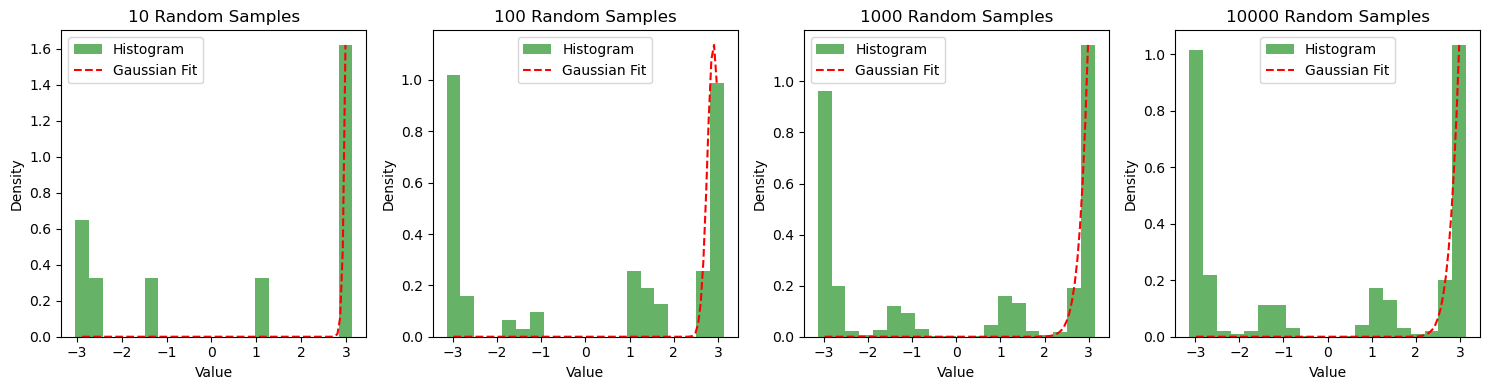

In [43]:
#Draw 10,100,1000,10000 random samples of a dihedral angle - FIT THEM TO A GAUSSIAN - WHY IS THIS FIT SO POOR?
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit

# Compute bond torsions
CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])

# Define the numbers of samples to draw
num_samples = [10, 100, 1000, 10000]

#define gaussian
def gaussian(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Plot histograms and fit Gaussians for each number of samples
plt.figure(figsize=(15, 4))
for i, num in enumerate(num_samples, start=1):
    plt.subplot(1, 4, i)
    
    # Generate random indices using np.random.randint
    random_indices = np.random.randint(0, len(CCCC_torsion), size=num)
    
    # Select random samples from the data array
    random_samples = CCCC_torsion[random_indices]
    
    # Plot histogram
    counts, edges = np.histogram(random_samples, bins=20, density=True)
    centers = (edges[:-1] + edges[1:]) / 2
    plt.hist(random_samples, bins=20, density=True, alpha=0.6, color='g', label='Histogram')
    
    # Fit Gaussian to the data
    # Compute initial parameter guesses
    initial_guess_a = max(counts)  # Initial guess for the peak height
    initial_guess_x0 = np.mean(centers)  # Initial guess for the peak position
    initial_guess_sigma = np.std(centers)  # Initial guess for the standard deviation

    # Define initial guesses as a tuple
    initial_guess = (initial_guess_x0, initial_guess_sigma, initial_guess_a)
    # Pass initial_guess to curve_fit function
    popt, _ = curve_fit(gaussian, centers, counts, p0=initial_guess)
    
    # Plot Gaussian fit
    x = np.linspace(min(centers), max(centers), 100)
    plt.plot(x, gaussian(x, *popt), 'r--', label='Gaussian Fit')
    
    plt.title(f'{num} Random Samples')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.show()
#Homework Answer
#This fit is so poor before dihedral torsion angles are periodic in nature. 

In [44]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

**Class Activity: Lets Compute the 2 C-C-C Bond Anlges and C-C-C-C Dihedral Angle ***

Plot their histograms.  Find a nice way to visualize the C-C-C-C dihedral angle 

(100000, 2)
[[1.932789  1.879369 ]
 [1.9745158 1.8898116]
 [2.0167994 1.9739912]
 ...
 [1.9203235 1.9527504]
 [1.924634  1.9177456]
 [1.9616427 2.0263684]]


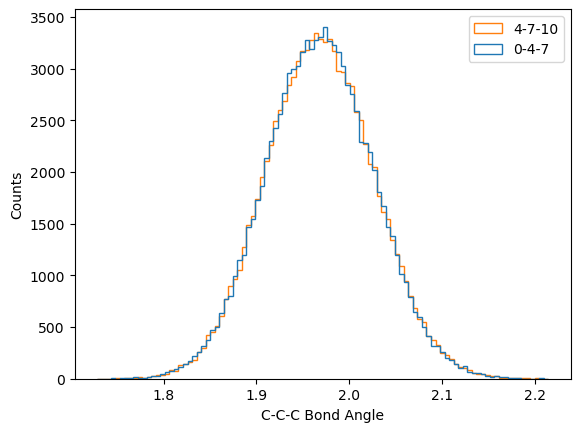

[[ 1.4267592]
 [ 1.4036077]
 [ 1.0046817]
 ...
 [-2.828031 ]
 [ 3.021616 ]
 [-3.12745  ]]
[[  81.74728]
 [  80.42079]
 [  57.56402]
 ...
 [-162.03424]
 [ 173.12584]
 [-179.18968]]


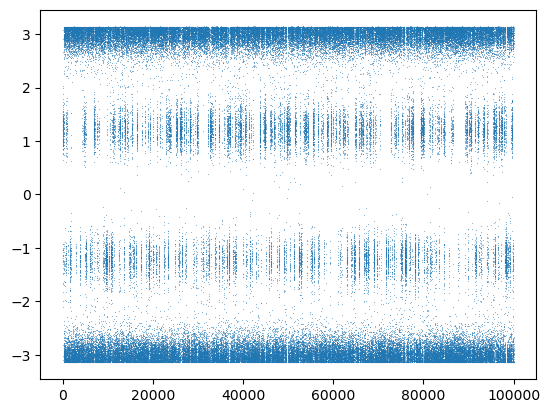

In [45]:
###Class Room Solution###
##Lets Compute Some Bond Angles & Torsions##
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])
print(np.shape(ang))
print(ang)

ang1=ang[:,0]
ang2=ang[:,1]

plt.plot(ang1,linewidth=0,marker='x',markersize=.1)
plt.plot(ang2,linewidth=0,marker='x',markersize=.1)
plt.clf()

plt.hist(ang,bins=100,histtype='step',label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('C-C-C Bond Angle')
plt.ylabel('Counts')
plt.show()
#plt.scatter(ang1,marker='o',s=0.1)

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
print(CCCC_torsion)
print(np.rad2deg(CCCC_torsion))

plt.plot(CCCC_torsion,marker='x',markersize=.1,linewidth=0)
#plt.xlim([0,100])

[[  81.74728]
 [  80.42079]
 [  57.56402]
 ...
 [-162.03424]
 [ 173.12584]
 [-179.18968]]


(0.0, 1000.0)

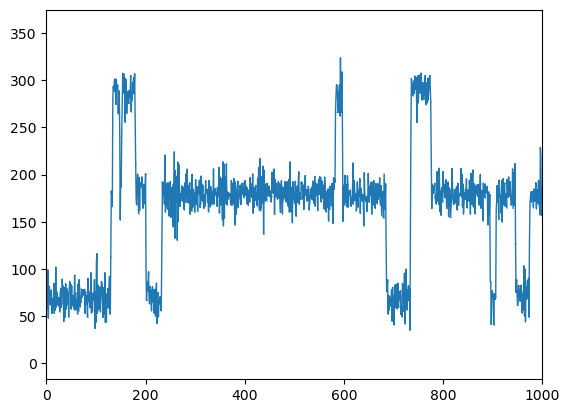

In [46]:
#print(np.where(CCCC_torsion<=0))
CCCC_tor_offset=np.rad2deg(CCCC_torsion)
print(CCCC_tor_offset)
for i in range(0,len(CCCC_tor_offset)):
    if(CCCC_tor_offset[i]<0):
        CCCC_tor_offset[i]+=360
        
plt.plot(np.abs(CCCC_tor_offset),marker='x',markersize=.1,linewidth=1)
plt.xlim([0,1000])

***Week 1 Homework Question:  What is the probability of being found in the higher free energy C-C-C-C dihedral state?*****

In [47]:
CCCC_dihe=CCCC_torsion[:,0]
a=np.where(CCCC_dihe<0)
print(a)
print(CCCC_dihe[a])

b=np.where(CCCC_dihe>-1)
print(b)
CCCC_dihe[b]
c=np.where((CCCC_dihe<0) & (CCCC_dihe>-2))
print(c)

(array([  131,   134,   135, ..., 99995, 99997, 99999], dtype=int64),)
[-3.096539  -1.3785379 -1.1592687 ... -3.130343  -2.828031  -3.12745  ]
(array([    0,     1,     2, ..., 99994, 99996, 99998], dtype=int64),)
(array([  134,   135,   136, ..., 99929, 99930, 99931], dtype=int64),)


In [48]:
####Week 1 Homework Question: What is the probability of being found in the higher free energy C-C-C-C dihedral state?####

#### Calculate Here #####
#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
CCCC_dihe
a=np.where(CCCC_dihe<0)
print(a)
CCCC_dihe[a]
b=np.where(CCCC_dihe>-2)
print(b)
CCCC_dihe[b]
c=np.where((CCCC_dihe<0) & (CCCC_dihe>-2))
print(c)
CCCC_dihe[c]
print(len(CCCC_dihe[c]) / len(CCCC_dihe))


(array([  131,   134,   135, ..., 99995, 99997, 99999], dtype=int64),)
(array([    0,     1,     2, ..., 99994, 99996, 99998], dtype=int64),)
(array([  134,   135,   136, ..., 99929, 99930, 99931], dtype=int64),)
0.08816


**Class Activity: Are The Bond Angles and Dihedral Angle Correlated?**

r2: 0.0011021609257102002


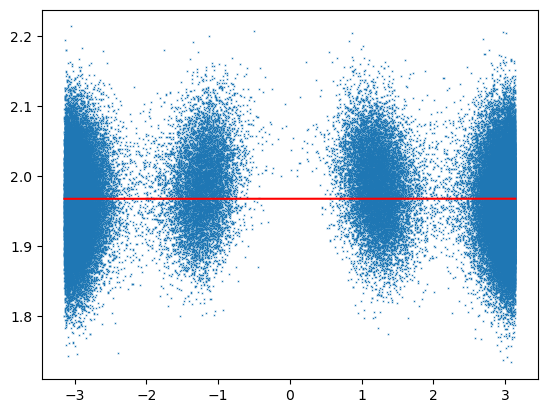

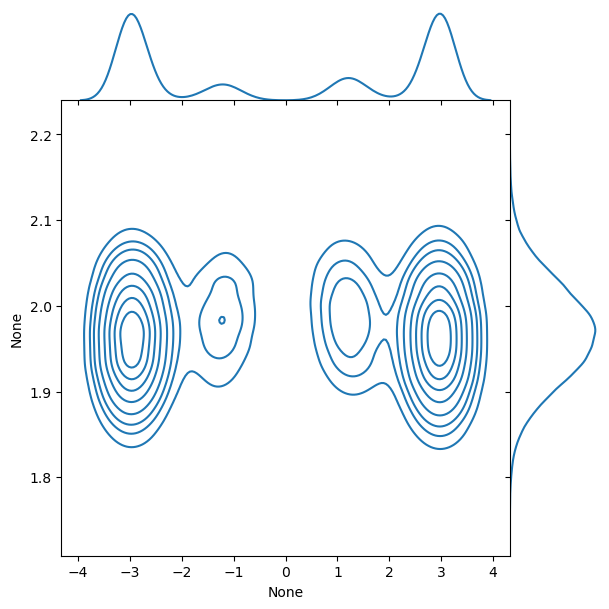

In [49]:
#### COMPLETE IN-CLASS ACTIVITY HERE #####
#Are the bond angle and dihedral correlated?
CCCC_dihe

plt.scatter(CCCC_dihe,ang1,marker='x',s=0.1)
r=np.corrcoef(CCCC_dihe,ang1)
print("r2:",r[0,1])
line_fit=np.polyfit(CCCC_dihe,ang1,1)
line_fit
x=np.linspace(min(CCCC_dihe),max(CCCC_dihe),20)
y = line_fit[1]+x*line_fit[0]
plt.plot(x,y,c='r',label='best fit line')
plt.show()
##### ADD FANCY SEABORN PLOT HERE ######
sns.jointplot(x=CCCC_dihe,y=ang1,kind='kde',space=0,thresh=0)



r2: -0.0004975587119301124


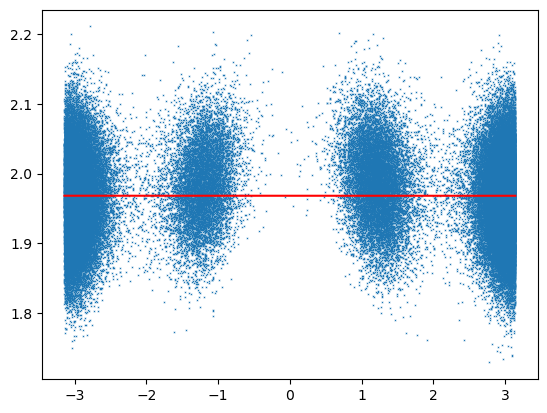

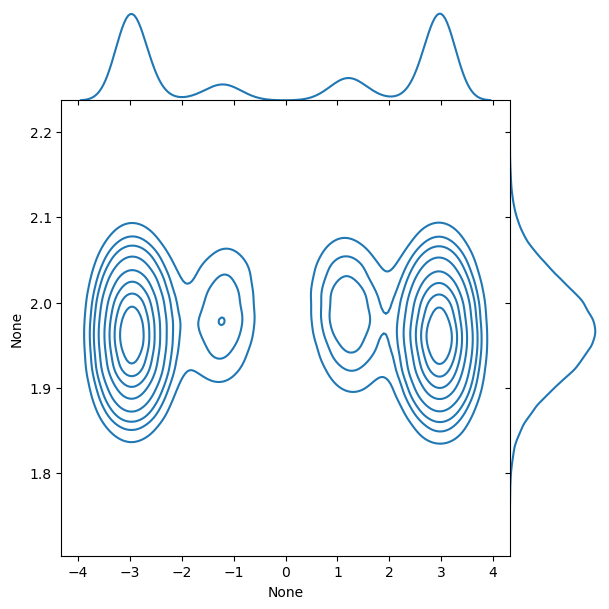

In [50]:
CCCC_dihe
plt.scatter(CCCC_dihe,ang2,marker='x',s=0.1)
r=np.corrcoef(CCCC_dihe,ang2)
print("r2:",r[0,1])
line_fit=np.polyfit(CCCC_dihe,ang2,1)
line_fit
x=np.linspace(min(CCCC_dihe),max(CCCC_dihe),20)
y = line_fit[1]+x*line_fit[0]
plt.plot(x,y,c='r',label='best fit line')
plt.show()
##### ADD FANCY SEABORN PLOT HERE ######
sns.jointplot(x=CCCC_dihe,y=ang2,kind='kde',space=0,thresh=0)

r2: 0.00013684530357165444


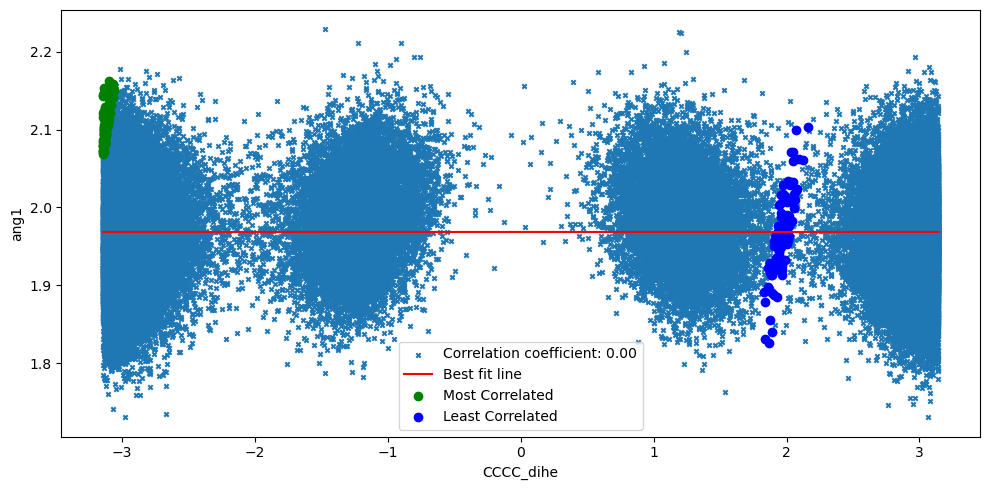

In [131]:
import numpy as np
import matplotlib.pyplot as plt
#data
CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])

Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])

ang1=ang[:,0]
ang2=ang[:,1]
# Calculate correlation coefficient
r = np.corrcoef(CCCC_dihe, ang1)[0, 1]
print("r2:", r)

# Fit a linear regression line
line_fit = np.polyfit(CCCC_dihe, ang1, 1)
x = np.linspace(min(CCCC_dihe), max(CCCC_dihe), 20)
y = line_fit[1] + x * line_fit[0]

# Plot original data and best fit line
plt.figure(figsize=(10, 5))

# Scatter plot of original data
plt.scatter(CCCC_dihe, ang1, marker='x', s=10, label=f'Correlation coefficient: {r:.2f}')
plt.xlabel('CCCC_dihe')
plt.ylabel('ang1')

# Plot the best fit line
plt.plot(x, y, c='r', label='Best fit line')

# Sort data based on the absolute value of correlation coefficient
sorted_indices = np.argsort(np.abs(CCCC_dihe - ang1))

# Plot the most correlated data (top 20 points)
most_correlated_indices = sorted_indices[-100:]
plt.scatter(CCCC_dihe[most_correlated_indices], ang1[most_correlated_indices], color='g', marker='o', label='Most Correlated')

# Plot the least correlated data (bottom 20 points)
least_correlated_indices = sorted_indices[:100]
plt.scatter(CCCC_dihe[least_correlated_indices], ang1[least_correlated_indices], color='b', marker='o', label='Least Correlated')

plt.legend()
plt.tight_layout()
plt.show()

**Homework Problem 3: Can you express the relationsip between these two quantites using histograms and conditional probabilities ?** 

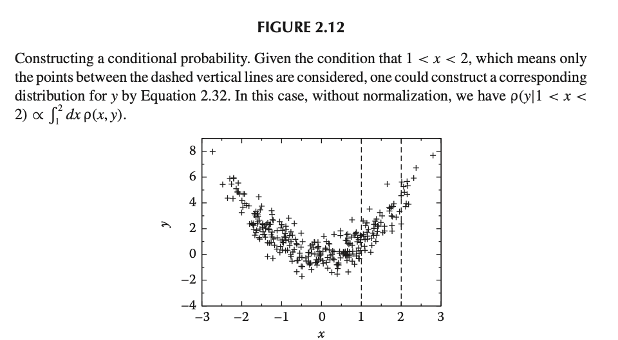

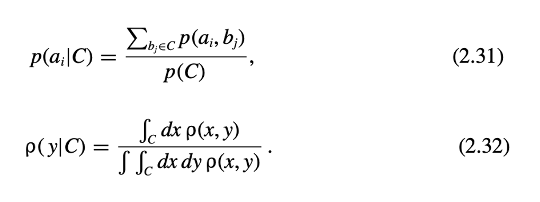

In [138]:
#Homework problem 3 Solution ##

#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html

CCCC_dihe=CCCC_torsion[:,0]
#Eclipsed is at 120, 240, 0, 360, 
#Highest energy would be at 0 and 360
# Define the torsion angle ranges
eclipsed1 = np.where((CCCC_dihe > (2.07)) & (CCCC_dihe < (2.11)))
print(len(CCCC_dihe[eclipsed1]) / len(CCCC_dihe))
eclipsed2 = np.where((CCCC_dihe < -(2.07)) & (CCCC_dihe > -(2.11)))
print(len(CCCC_dihe[eclipsed1]) / len(CCCC_dihe))
highest_energy_eclipsed = np.where((CCCC_dihe > -(0.02)) & (CCCC_dihe < (0.02)))
print(len(CCCC_dihe[highest_energy_eclipsed]) / len(CCCC_dihe))

# Print the resulting indices
print(eclipsed1)
print(eclipsed2)
print(highest_energy_eclipsed)

0.00023
0.00023
1e-05
(array([  953,  1445,  5679,  9098, 11808, 13910, 15186, 23145, 31936,
       42392, 43320, 44011, 49167, 53714, 56063, 67380, 68019, 75692,
       81377, 82883, 88985, 90360, 99513], dtype=int64),)
(array([ 1691, 18830, 21480, 23581, 38195, 38375, 38764, 50495, 50680,
       51900, 53591, 58420, 60247, 62020, 69080, 72032, 72071, 72318,
       72901, 89589, 91390, 95767, 97847], dtype=int64),)
(array([87348], dtype=int64),)


In [133]:
#Will Walk through example of Autocorrelation Function (ACF) calculation here#
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)
    
print(ang1)
print(ang1[1:])
print(ang1[:-1])

[2.0141482 2.037249  1.9978203 ... 2.0303986 1.9933378 2.0793993]
[2.037249  1.9978203 2.038968  ... 2.0303986 1.9933378 2.0793993]
[2.0141482 2.037249  1.9978203 ... 1.895183  2.0303986 1.9933378]


**Class Activity: Lets Calculate the Autocorrelation Times of C-C Bonds, C-C-C Angles, and C-C-C-C Dihedrals**

https://ipython-books.github.io/103-computing-the-autocorrelation-of-a-time-series/

[0.00000e+00 2.00002e-01 4.00004e-01 ... 1.99996e+04 1.99998e+04
 2.00000e+04]


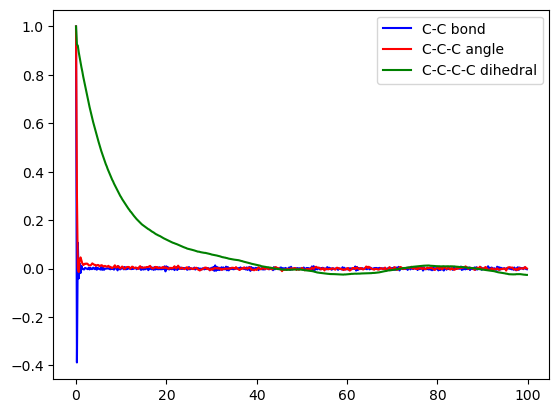

In [48]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
bond_autocor=autocorr1(C1C2bondlength[:,0],lags)
ang_autocor=autocorr1(ang1,lags)
dihe_autocor=autocorr1(np.cos(CCCC_torsion[:,0]),lags)
plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')
plt.legend()

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

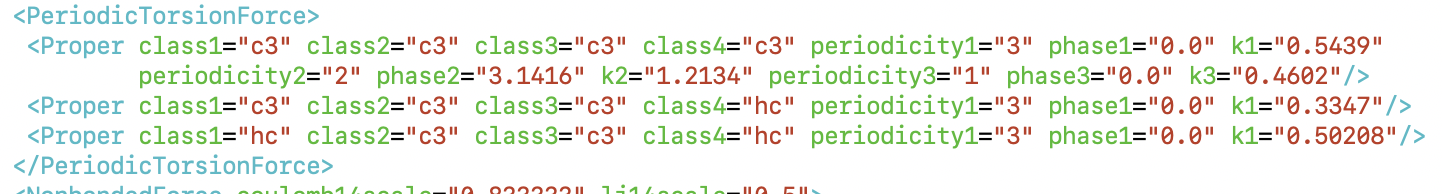

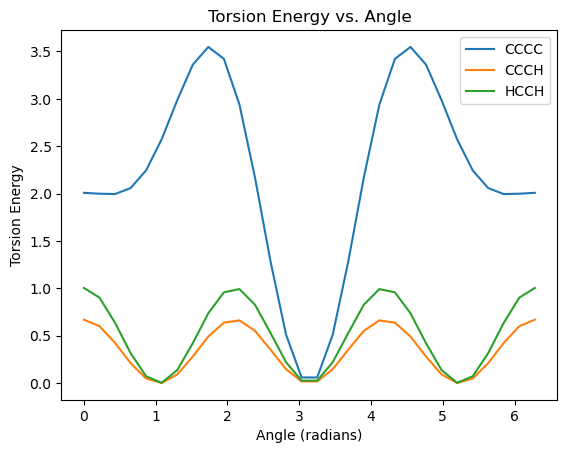

In [51]:
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms

#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

def CCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.3347,3,0)
 return e1

def HCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.50208,3,0)
 return e1

CCCC_e=CCCC_torsionE(rad_ang)
CCCH_e=CCCH_torsionE(rad_ang)
HCCH_e=HCCH_torsionE(rad_ang)


#plt.plot(rad_ang,CCCC_e)
#plt.plot(rad_ang,CCCH_e)
#plt.plot(rad_ang,HCCH_e)
plt.plot(rad_ang, CCCC_e, label='CCCC')
plt.plot(rad_ang, CCCH_e, label='CCCH')
plt.plot(rad_ang, HCCH_e, label='HCCH')
plt.legend()  # Add legend
plt.xlabel('Angle (radians)')
plt.ylabel('Torsion Energy')
plt.title('Torsion Energy vs. Angle')
plt.show()

In [50]:
##Lets Review all our atoms as we attempt to tabulate all the relevant torsion terms
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

In [52]:
#Lets Consider Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Lets Tally Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Central Torsion: 
#C-C-C-C -[10,7,4,0]
#H-C-C-H; [8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6]  
#H-C-C-H; [6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3]
#H-C-C-H; [13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]
#C-C-C-H -[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

CCCC_index=[10,7,4,0]
HCCH_indices=[[8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6],[6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3],[13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]]
CCCH_indices=[[10,7,4,5],[10,7,4,6],[7,4,0,3],[7,4,0,2],[7,4,0,1],[4,7,10,13],[4,7,10,12],[4,7,10,11], [0,4,7,8], [0,4,7,9]]

HCCH_torsions=md.compute_dihedrals(traj, HCCH_indices)
CCCH_torsions=md.compute_dihedrals(traj, CCCH_indices)
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])


In [53]:
print(HCCH_indices)
print(HCCH_torsions)

[[8, 7, 4, 5], [8, 7, 4, 6], [9, 7, 4, 5], [9, 7, 4, 6], [6, 4, 0, 1], [6, 4, 0, 2], [6, 4, 0, 3], [5, 4, 0, 1], [5, 4, 0, 2], [5, 4, 0, 3], [13, 10, 7, 8], [12, 10, 7, 8], [11, 10, 7, 8], [13, 10, 7, 9], [12, 10, 7, 9], [11, 10, 7, 9]]
[[ 1.216299   -3.0921643  -0.77571553 ...  1.0165547  -3.038573
  -0.85980105]
 [ 1.3624002  -2.7092361  -0.7403461  ...  0.73486805  2.87375
  -1.2580689 ]
 [ 1.090371    3.0534356  -1.0024723  ...  0.69384575  2.8917007
  -1.3035964 ]
 ...
 [ 3.138956   -1.0715508   1.076723   ... -1.1132468   0.9893702
  -3.0883954 ]
 [ 3.007746   -0.9553523   0.8532988  ... -1.0840975   1.059602
  -3.0328696 ]
 [-2.9990242  -1.067599    1.2404052  ... -1.1205468   1.0534039
  -3.0942295 ]]


**Homework Problem #5: Many of These Correlations will be highly Correlated Select Some Torsions that are Correlated, and some that are not, and make scatter plots of their relationships**

For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?  

For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

r2: 0.24859419516648826


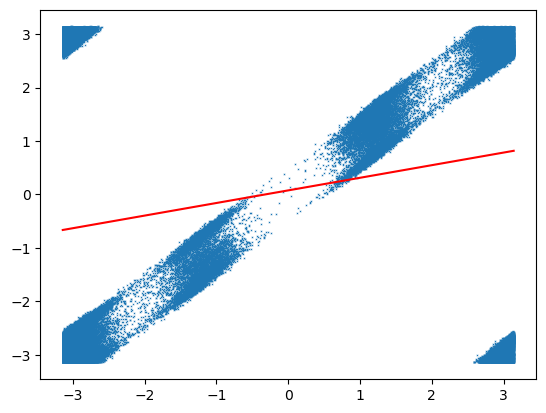

r2: 0.24859419516648826


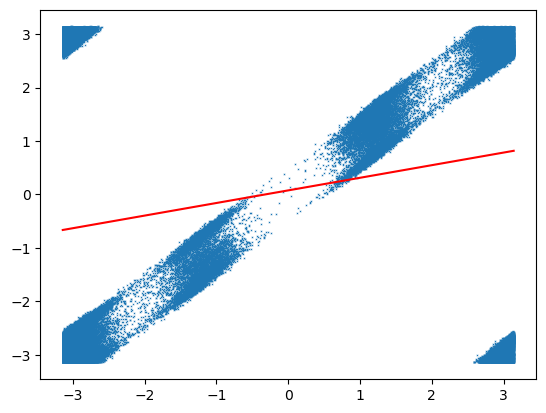

In [80]:
####WEEK 1 Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Perhaps Consider CCCC vs. [8,7,4,5]
plt.scatter(CCCC_torsion[:,0], CCCH_torsions[:,0],marker='x',s=0.1)
r=np.corrcoef(CCCC_torsion[:,0], CCCH_torsions[:,0])
print("r2:",r[0,1])
line_fit=np.polyfit(CCCC_torsion[:,0], CCCH_torsions[:,0],1)
line_fit
x=np.linspace(min(CCCC_torsion),max(CCCC_torsion),20)
y = line_fit[1]+x*line_fit[0]
plt.plot(x,y,c='r',label='best fit line')
plt.show()



#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Perhaps Consider CCCC vs. [12,10,7,9]?

#For Example:
plt.scatter(CCCC_torsion[:,0], CCCH_torsions[:,0],marker='x',s=0.1)
r=np.corrcoef(CCCC_torsion[:,0], CCCH_torsions[:,0])
print("r2:",r[0,1])
line_fit=np.polyfit(CCCC_torsion[:,0], CCCH_torsions[:,0],1)
line_fit
x=np.linspace(min(CCCC_torsion),max(CCCC_torsion),20)
y = line_fit[1]+x*line_fit[0]
plt.plot(x,y,c='r',label='best fit line')
plt.show()


**Homework Problem #6: SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT**

r2: 0.627903320599435


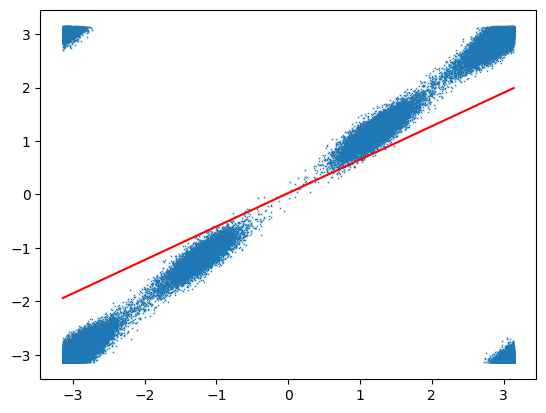

Text(0.5, 0, 'frame')

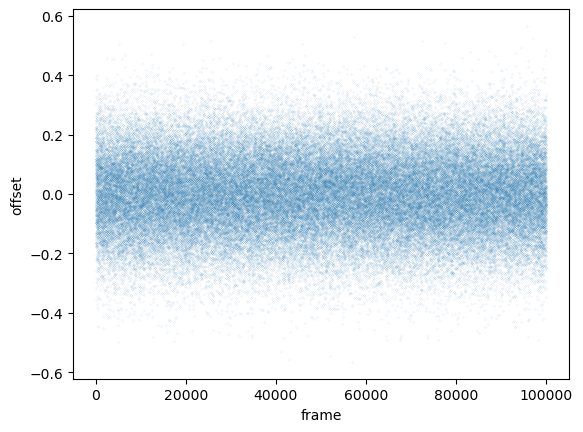

In [90]:
#SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
#CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT
offset_diff = CCCC_torsion[:,0] - HCCH_torsions[:,0]
offset_diff = np.where(offset_diff<-3.2, offset_diff + 2*np.pi, offset_diff)
offset_diff = np.where(offset_diff>3.2, offset_diff - 2*np.pi, offset_diff)
plt.scatter(CCCC_torsion[:,0], HCCH_torsions[:,0],marker='x',s=0.1)
r=np.corrcoef(CCCC_torsion[:,0], HCCH_torsions[:,0])
print("r2:",r[0,1])
line_fit=np.polyfit(CCCC_torsion[:,0], HCCH_torsions[:,0],1)
line_fit
x=np.linspace(min(CCCC_torsion),max(CCCC_torsion),20)
y = line_fit[1]+x*line_fit[0]
plt.plot(x,y,c='r',label='best fit line')
plt.show()
#offset_diff -2*np.pi,
plt.plot(offset_diff, marker=".", markersize=0.1, linestyle="none")
plt.ylabel("offset")
plt.xlabel("frame")

***WEEK 2 Homework Problem #1: Lets modify the C-C-C-C Torsion Potential to change the dihedral distribution***


Lets try to lower the dihedral barriers for torsion angles of 1 radian (~60 degrees)
This means we need to to come up with a torsion potential, potentially by using multiple terms with different phases, to equalize the free energy of each C-C-C-C torsion basin (increasing the free energy at $\pi$ and lowering 
free energy at $\pi$/3

Once you've come up with torsion terms you're happy with, you'll need to make a copy of the butane.gaff2.xml, add in the additional torsion terms you have come up with, and run a new simulation.  Then plot the C-C-C-C dihedral histogram or PMF, and compare it to the simulation with original force field.

It would be great if you came up with some kind of fitting routine to determine the coefficients of torsions, perhaps by targeting a gaussian, or you can try to arrive at by hand using something like this:

https://www.desmos.com/calculator/ea1qhzjnuf

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

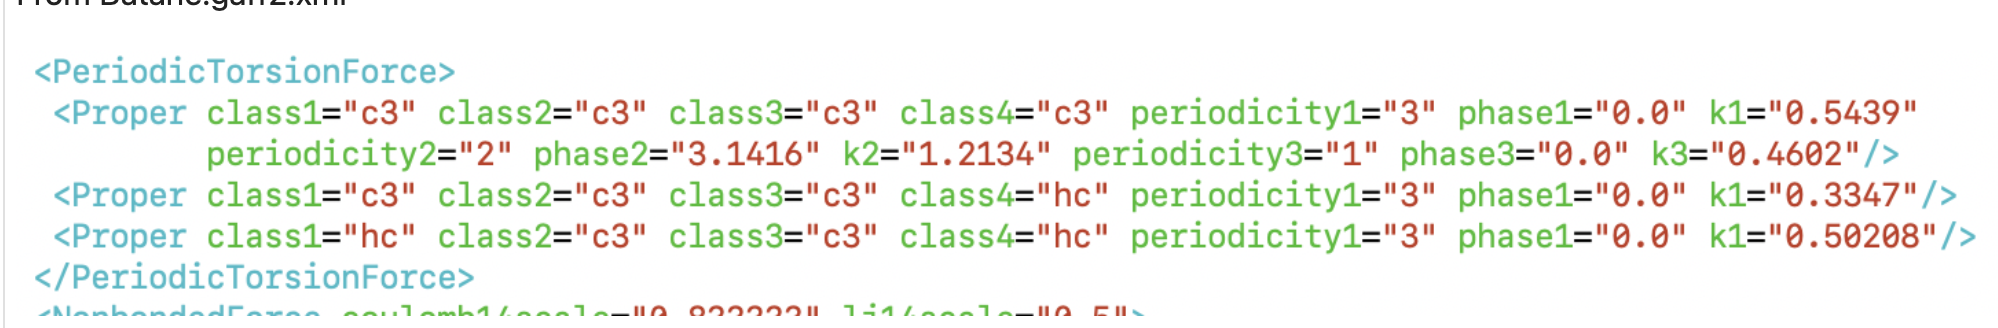

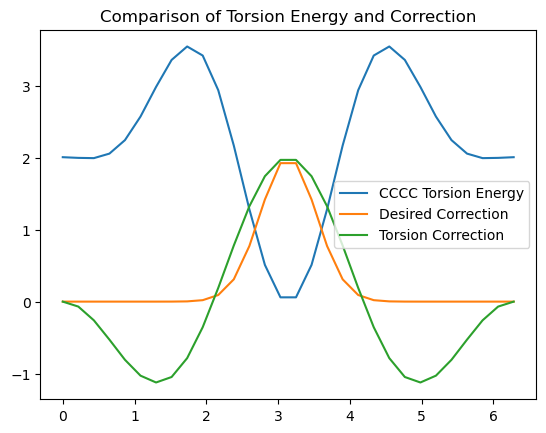

In [65]:
###SOLUTION#####

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms

def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

plt.plot(rad_ang, CCCC_e, label='CCCC Torsion Energy')

#We want to mimic a gaussian potential that adds potential energy when the CCCC diehdral = pi = 180 degrees
#We can think of this as approximating a guassian center at theta= 180
###Now we define a gaussian function that we'll fit to our probability densities

def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

#Here is what we want our dihedral correction to look like:

gauss_cor = gauss(rad_ang, 2, np.pi, np.pi/8)
plt.plot(rad_ang, gauss_cor, label='Desired Correction')

#Here I come up with a correction that should have the desired effect:

def TorsionCorrection(angle):
 e1=calc_torsion_energy(angle,-1,1,0)
 e2=calc_torsion_energy(angle,1,2,0)
 #3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2

torsion_cor = TorsionCorrection(rad_ang)
plt.plot(rad_ang, torsion_cor, label='Torsion Correction')

## Add title and legend
plt.title('Comparison of Torsion Energy and Correction')
plt.legend()

plt.show()

***WEEK 2 Homework Problem #2 Attempt to run a new MD Simulation with your modified torsion potential***

Once you have made a torsion correction you like make a new force field file 'butane.gaff2.cor1.xml'.

Run a new simulation with this force field and compare the dihedral distributions 

In [93]:
#RUN NEW MD SIMULATION HERE#
#Change forcefield and name soething new,
#copy everything from the beginning down here, calling in new forcefield
#jump straight to the torsions
import numpy as np
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

import sys
import openmm as mm
from openmm import app
from openmm import unit
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import pandas as pd
from statistics import mean, stdev
from matplotlib import colors
import mdtraj as md
import seaborn as sns



In [96]:
workdir='./work_tors/'
datadir='./data/'
outdir='./out_tors/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2_correction.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)


./data/butane.pdb
./data/butane.gaff2_correction.xml


In [97]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 6.997528691301373 kJ/mol
Potential energy after minimization is 6.495271673130704 kJ/mol


In [98]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,30.477806362218516,244.60340517154566
2000,37.23106511965783,151.88117234322343


In [99]:
os.path.join(workdir, "butane_sim2.dcd")

'./work_tors/butane_sim2.dcd'

In [100]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD or XTC
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.XTCReporter(os.path.join(workdir, "butane_sim2.xtc"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,48.77824198837153,308.67332731687355,--
500000,999.9999999901769,39.29966760100305,268.5963611783422,9.12e+03
750000,1499.9999999783536,44.12494873200603,369.27810740534187,9.18e+03
1000000,1999.9999999665301,30.647778181066553,249.91305437784095,8.89e+03
1250000,2499.9999999547067,70.03985834028359,374.9633212291784,8.84e+03
1500000,2999.9999999428833,45.477169268428845,195.05691225144267,8.75e+03
1750000,3499.99999993106,43.67368781125222,316.6942984388988,8.63e+03
2000000,3999.9999999192364,44.71773662500577,216.68113818241284,8.56e+03
2250000,4499.9999999992715,45.32678617835171,211.34103991298375,8.44e+03
2500000,5000.000000101135,39.45984111989745,260.9677136353756,8.53e+03
2750000,5500.000000202998,29.68241753434408,296.4898005451755,8.56e+03
3000000,6000.000000304862,20.923638448947813,268.2270008938545,8.56e+03
3250000,6500.000000406725,48.71297406

In [102]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_sim2.xtc"), top=PDB_file_name)
traj


<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x185695467d0>

In [103]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

In [105]:
#Calc CCCC torsion
CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
print(CCCC_torsion)
print(np.rad2deg(CCCC_torsion))

[[-1.4101254]
 [-0.9341583]
 [-1.3381615]
 ...
 [ 3.1378205]
 [ 3.1179988]
 [-2.5400903]]
[[ -80.79423 ]
 [ -53.523327]
 [ -76.671   ]
 ...
 [ 179.78386 ]
 [ 178.64816 ]
 [-145.53645 ]]


In [107]:

CCCC_index=[10,7,4,0]
HCCH_indices=[[8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6],[6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3],[13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]]
CCCH_indices=[[10,7,4,5],[10,7,4,6],[7,4,0,3],[7,4,0,2],[7,4,0,1],[4,7,10,13],[4,7,10,12],[4,7,10,11], [0,4,7,8], [0,4,7,9]]

HCCH_torsions=md.compute_dihedrals(traj, HCCH_indices)
CCCH_torsions=md.compute_dihedrals(traj, CCCH_indices)
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])



In [110]:

#Plot The Torsion Force Field Terms


In [54]:
#Compare New Dihedral Distribution HERE)

**WEEK 2 Homework Problem #3 Plot the LJ and Coulumb Forcefield Potentials for 3 types of atom pairs**

#CHECK THE COMBINATION RULES USED FOR OPENMM##


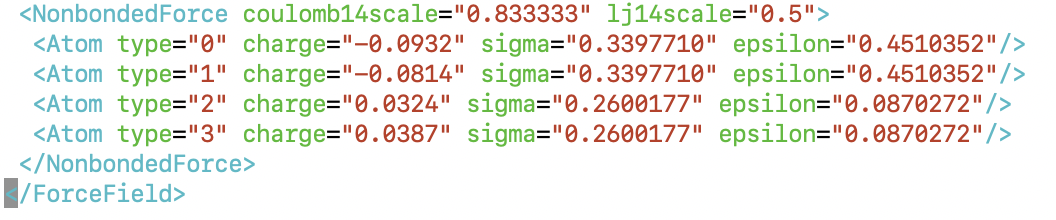




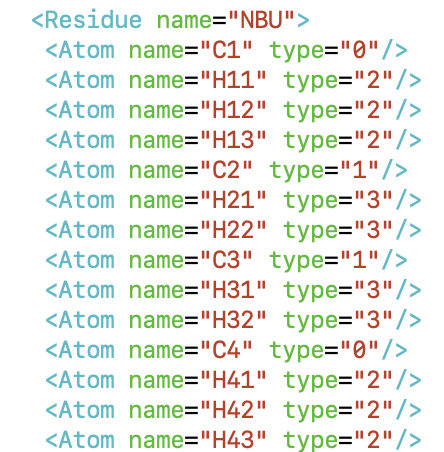

In [ ]:
#Plot LJ and Couloumb Potentionals Here

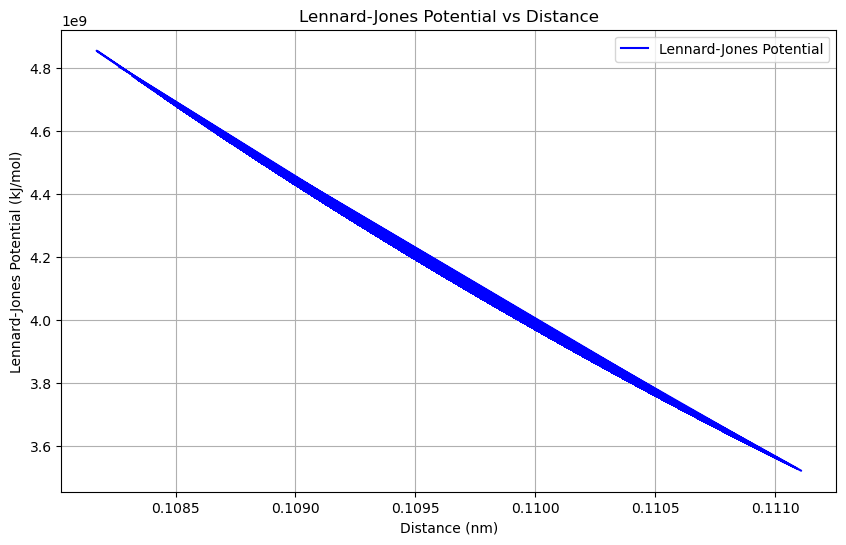

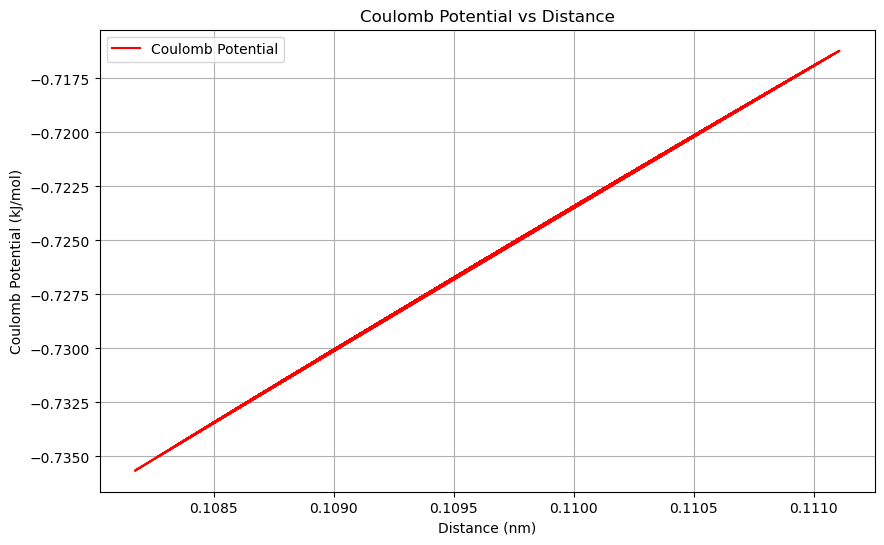

In [69]:
#Atom pair types 0, 2
import numpy as np
import matplotlib.pyplot as plt

# Define LJ function with different sigma and epsilon values for each atom type
def lj(r, sigma_i, sigma_j, epsilon_i, epsilon_j):
    return 4 * np.sqrt(epsilon_i * epsilon_j) * ((sigma_i + sigma_j) / r) ** 12 - ((sigma_i + sigma_j) / r) ** 6

# Define Coulomb function
def coulomb(q1, q2, r, dielectric_constant=1.0):
    return (1.0 / (4 * np.pi * dielectric_constant)) * q1 * q2 / r

# Define atom indices
atom_i = 0  # Index of the first atom
atom_j = 1  # Index of the second atom

bond_indices = [0, 1] 
distances = md.compute_distances(traj, [bond_indices])

# Define LJ parameters for each atom type
sigma_values = [0.3, 0.35]  # Sigma values for atom types 0 and 2
epsilon_values = [0.5, 0.6]  # Epsilon values for atom types 0 and 2

# Define Coulomb parameters
q1 = 1.0  # Charge of the first atom
q2 = -1.0  # Charge of the second atom

# Compute LJ potentials with different sigma and epsilon values
lj_potentials = lj(distances, sigma_values[atom_i], sigma_values[atom_j], epsilon_values[atom_i], epsilon_values[atom_j])

# Compute Coulomb potentials
coulomb_potentials = coulomb(q1, q2, distances)

# Plot LJ potential versus distance
plt.figure(figsize=(10, 6))
plt.plot(distances, lj_potentials, label='Lennard-Jones Potential', color='blue')
plt.xlabel('Distance (nm)')
plt.ylabel('Lennard-Jones Potential (kJ/mol)')
plt.title('Lennard-Jones Potential vs Distance')
plt.legend()
plt.grid(True)
plt.show()

# Plot Coulomb potential versus distance
plt.figure(figsize=(10, 6))
plt.plot(distances, coulomb_potentials, label='Coulomb Potential', color='red')
plt.xlabel('Distance (nm)')
plt.ylabel('Coulomb Potential (kJ/mol)')
plt.title('Coulomb Potential vs Distance')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Atom pair types 1 and 3
# Define LJ and Coulomb functions
def lj(r, sigma, epsilon):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

def coulomb(q1, q2, r, dielectric_constant=1.0):
    return (1.0 / (4 * np.pi * dielectric_constant)) * q1 * q2 / r

# Define atom indices
atom_i = 4  # Index of the first atom
atom_j = 5  # Index of the second atom

# Compute distances between the specified pair of atoms
atom_pair = np.array([[atom_i, atom_j]])
distances = md.compute_distances(traj, atom_pair, periodic=True)

# Compute LJ and Coulomb potentials
sigma_value = 0.3  # Replace with your sigma value
epsilon_value = 0.5  # Replace with your epsilon value
q1 = 1.0  # Charge of the first atom
q2 = -1.0  # Charge of the second atom

lj_potentials = lj(distances, sigma_value, epsilon_value)
coulomb_potentials = coulomb(q1, q2, distances)

In [ ]:
#Atom pair types 0 and 0
# Define LJ and Coulomb functions
def lj(r, sigma, epsilon):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

def coulomb(q1, q2, r, dielectric_constant=1.0):
    return (1.0 / (4 * np.pi * dielectric_constant)) * q1 * q2 / r

# Define atom indices
atom_i = 0  # Index of the first atom
atom_j = 10  # Index of the second atom

# Compute distances between the specified pair of atoms
atom_pair = np.array([[atom_i, atom_j]])
distances = md.compute_distances(traj, atom_pair, periodic=True)

# Compute LJ and Coulomb potentials
sigma_value = 0.3  # Replace with your sigma value
epsilon_value = 0.5  # Replace with your epsilon value
q1 = 1.0  # Charge of the first atom
q2 = -1.0  # Charge of the second atom

lj_potentials = lj(distances, sigma_value, epsilon_value)
coulomb_potentials = coulomb(q1, q2, distances)